In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip "drive/My Drive/Proyecto IA II/data_aug_4_classes/data_aug_4_classes.zip"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: base_dir/image_train/insect/42384942895_654682ffc2_n.jpg  
  inflating: base_dir/image_train/insect/_655_5530647.jpg  
  inflating: base_dir/image_train/insect/_1240_4776834.jpg  
  inflating: base_dir/image_train/insect/_1094_3530858.jpg  
  inflating: base_dir/image_train/insect/_286_8359104.jpg  
  inflating: base_dir/image_train/insect/27466882187_1233cb9f79_m.jpg  
  inflating: base_dir/image_train/insect/_1115_8115449.jpg  
  inflating: base_dir/image_train/insect/3791132058_00669c7924_n.jpg  
  inflating: base_dir/image_train/insect/8709079109_850c548a49_n.jpg  
  inflating: base_dir/image_train/insect/34616636634_3d10c5eb5b_n.jpg  
  inflating: base_dir/image_train/insect/2798040684_7425ed042c_m.jpg  
  inflating: base_dir/image_train/insect/_1129_319270.jpg  
  inflating: base_dir/image_train/insect/_963_779912.jpg  
  inflating: base_dir/image_train/insect/_676_148052.jpg  
  inflating: base_dir/image_t

In [ ]:
#@title **Librerias**
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report, roc_auc_score

In [ ]:
#MODELO RESNET50 CON TRANSFER LEARNING Y FINE-TUNNING 

#CARGANDO EL MODELO CON LOS PESOS PRE-ENTRENADOS DE IMAGENET
base_model = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3),
     classes=4, pooling='max', classifier_activation='softmax') 

base_model.trainable = True
set_trainable = False

#FINE TUNNING DEL ÚLTIMO BLOQUE CONVOLUCIONAL
for layer in base_model.layers:
  if layer.name == 'conv4_block4_3_conv':
    set_trainable = True
  if set_trainable: 
    layer.trainable = True
  else:
    layer.trainable = False

base_model.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
#PLANTEAMIENTO DEL MODELO SECUENCIAL Y ADICIÓN DE LAS ÚLTIMAS CAPAS DE SALIDA
model = Sequential()
model.add(base_model)
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(4, activation="softmax")) #FUNCIÓN DE ACTIVACIÓN SOFTMAX, OUTPUT 7 CLASES 

model.compile(Adam(0.001), loss="categorical_crossentropy", metrics=[categorical_accuracy])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1

In [ ]:
#CARGAR LOS DATOS
train_dir='/content/base_dir/image_train'
val_dir='/content/base_dir/image_val'
test_dir='/content/base_dir/image_test'

IMAGE_SHAPE = (224, 224, 3)
batch_size = 32

data_generator = ImageDataGenerator()

train_flow_param = {
    "directory": train_dir,
    "batch_size": batch_size,
    "target_size": IMAGE_SHAPE[:2],
}
train_flow = data_generator.flow_from_directory(**train_flow_param)

val_flow_param = {
    "directory": val_dir,
    "batch_size": batch_size,
    "target_size": IMAGE_SHAPE[:2],
    "shuffle": False 
}
val_flow = data_generator.flow_from_directory(**val_flow_param)

test_flow_param = {
    "directory": test_dir,
    "target_size": IMAGE_SHAPE[:2],
    "batch_size" : 1,
    "shuffle": False 
}
test_flow = data_generator.flow_from_directory(**test_flow_param)

Found 15875 images belonging to 4 classes.
Found 1142 images belonging to 4 classes.
Found 1143 images belonging to 4 classes.


In [ ]:
#PARAMETROS PARA EL ENTRENAMIENTO

filepath = "model.h5"

checkpoint_param = {
    "filepath": filepath,
    "monitor": "val_categorical_accuracy",
    "verbose": 1,
    "save_best_only": True,
    "mode": "max"
}
checkpoint = ModelCheckpoint(**checkpoint_param)

lr_decay_params = {
    "monitor": "val_loss",
    "factor": 0.5,
    "patience": 2,
    "min_lr": 1e-5
}
lr_decay = ReduceLROnPlateau(**lr_decay_params)

In [ ]:
#ENTRENAMIENTO

fit_params = {
    "generator": train_flow,
    "steps_per_epoch": train_flow.n // batch_size,
    "epochs": 20,
    "verbose": 1,
    "validation_data": val_flow,
    "validation_steps": val_flow.n // batch_size,
    "callbacks": [checkpoint, lr_decay]
}
print("Training the model...")

history = model.fit_generator(**fit_params)

print("Done!")

Training the model...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
496/496 [==============================] - 96s 172ms/step - loss: 0.3940 - categorical_accuracy: 0.8733 - val_loss: 0.2290 - val_categorical_accuracy: 0.9134

Epoch 00001: val_categorical_accuracy improved from -inf to 0.91339, saving model to model.h5
Epoch 2/20
496/496 [==============================] - 86s 172ms/step - loss: 0.1272 - categorical_accuracy: 0.9549 - val_loss: 0.2584 - val_categorical_accuracy: 0.9045

Epoch 00002: val_categorical_accuracy did not improve from 0.91339
Epoch 3/20
496/496 [==============================] - 86s 174ms/step - loss: 0.0776 - categorical_accuracy: 0.9773 - val_loss: 0.2464 - val_categorical_accuracy: 0.9214

Epoch 00003: val_categorical_accuracy improved from 0.91339 to 0.92143, saving model to model.h5
Epoch 4/20
496/496 [==============================] - 87s 176ms/step - loss: 0.0404 - categorical_accuracy: 0.9870 - val_loss: 0.2304 - val_categorical_accuracy: 0.9312

Epoch 00004: val_categorical_accuracy improved from 0.92143 to

In [ ]:
#Evaluar el modelo con categorical accuracy y f1_score en la validacion
y_val_true = val_flow.classes
y_val_pred = np.argmax(model.predict_generator(val_flow, steps=len(val_flow)), axis=1)

_, val_acc = model.evaluate_generator(val_flow, steps=len(val_flow))
val_precision_score = precision_score(y_val_true, y_val_pred, average="weighted")
val_f1_score = f1_score(y_val_true, y_val_pred, average="weighted")
val_recall_score = recall_score(y_val_true, y_val_pred, average='weighted')

print("Validation accuracy: {:.4f}".format(val_acc))
print("Validation Precision: {:.4f}".format(val_precision_score))
print("Validation F1 score: {:.4f}".format(val_f1_score))
print("Validation Recall score: {:.4f}".format(val_recall_score))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Validation accuracy: 0.9422
Validation Precision: 0.9426
Validation F1 score: 0.9422
Validation Recall score: 0.9422


In [ ]:
#Evaluar el modelo con categorical accuracy y f1_score en el test

y_test_true = test_flow.classes
y_test_pred = np.argmax(model.predict_generator(test_flow, steps=len(test_flow)), axis=1)

_, test_acc = model.evaluate_generator(test_flow, steps=len(test_flow))
test_precision_score = precision_score(y_test_true, y_test_pred, average="weighted")
test_f1_score = f1_score(y_test_true, y_test_pred, average="weighted")
test_recall_score = recall_score(y_test_true, y_test_pred, average='weighted')

print("Test accuracy: {:.4f}".format(test_acc))
print("Test Precision: {:.4f}".format(test_precision_score))
print("Test F1 score: {:.4f}".format(test_f1_score))
print("Test Recall score: {:.4f}".format(test_recall_score))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test accuracy: 0.9458
Test Precision: 0.9460
Test F1 score: 0.9456
Test Recall score: 0.9458


In [ ]:
#OBTENER EL HISTORIAL DE LOS DATOS DEL ENTRENAMIENTO

loss_train = history.history["loss"]
acc_train = history.history["categorical_accuracy"]
loss_val = history.history["val_loss"]
acc_val = history.history["val_categorical_accuracy"]
epochs = np.arange(1, len(loss_train) + 1)

print("Loss Train = " + str(loss_train))
print("Acc Train = " + str(acc_train))
print("Loss Val = " + str(loss_val))
print("Acc Val = " + str(acc_val))

Loss Train = [0.27652639150619507, 0.13524094223976135, 0.0802336260676384, 0.03675980865955353, 0.01585397683084011, 0.009581728838384151, 0.006728457286953926, 0.005124447401612997, 0.004712022375315428, 0.003084751544520259, 0.004920286126434803, 0.003048619953915477, 0.003173109609633684, 0.002250053221359849, 0.0018396804807707667, 0.001599590410478413, 0.001878060051240027, 0.0015508785145357251, 0.0026709348894655704, 0.0014774040319025517]
Acc Train = [0.9064571261405945, 0.9529129862785339, 0.975383460521698, 0.987881064414978, 0.9957078695297241, 0.9977276921272278, 0.9984851479530334, 0.9988638758659363, 0.9985482692718506, 0.9993687868118286, 0.9988638758659363, 0.9988007545471191, 0.9991794228553772, 0.9991794228553772, 0.99955815076828, 0.99955815076828, 0.9994950294494629, 0.9994950294494629, 0.9994950294494629, 0.9994950294494629]
Loss Val = [0.22896233201026917, 0.2583974003791809, 0.24642203748226166, 0.23044218122959137, 0.2381790429353714, 0.27754825353622437, 0.257

In [ ]:
os.mkdir('Resultados')

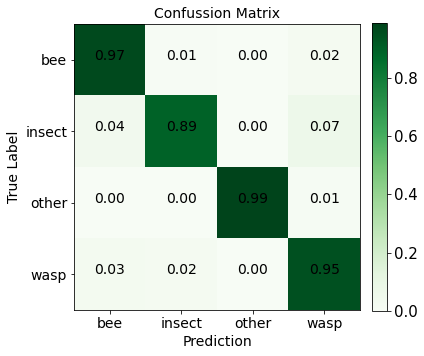

In [ ]:
#MATRIZ DE CONFUSION

import itertools
import matplotlib.pyplot as plt

labels = ['bee', 'insect', 'other', 'wasp']
conf_mat = confusion_matrix(y_test_true, y_test_pred)
conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis=1, keepdims=True)
prediction = model.predict(test_flow, batch_size=16)
hide_ticks =True
plt.figure(figsize= (6,6))

def plot_confusion_matrix(cm,
                          normalize=False,
                          cmap=plt.cm.Greens,
                          axis=1): 

    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=15) 
    plt.xticks(range(4), labels, fontsize=14)
    plt.yticks(range(4), labels, fontsize=14)

    fmt = '.2f' if normalize else '.2f'
    thresh = 50
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=14)

    plt.ylabel('True Label',fontsize=14)
    plt.xlabel('Prediction',fontsize=14)
    plt.title('Confussion Matrix',fontsize=14)
    plt.tight_layout()
plot_confusion_matrix(conf_mat)
plt.savefig("Resultados/confussion.pdf", bbox_inches="tight")
plt.savefig("Resultados/confussion.png", bbox_inches="tight")

In [ ]:
FP = conf_mat.sum(axis=0) - np.diag(conf_mat) 
FN = conf_mat.sum(axis=1) - np.diag(conf_mat)
TP = np.diag(conf_mat)
TN = conf_mat.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Specificity or true negative rate
TNR = TN/(TN+FP) 

print("Test Spec:", TNR)
print("Test Spec:", np.mean(TNR))

Test Spec: [0.97691119 0.99050273 0.9993266  0.96690598]
Test Spec: 0.9834116248665845


In [ ]:
#CALCULAR ROC AUC PARA CLASIFICACION MULTICLASE 
test_roc_auc_score1 = roc_auc_score(y_test_true, prediction, average="macro", multi_class="ovo")
test_roc_auc_score2 = roc_auc_score(y_test_true, prediction, average="macro", multi_class="ovr")
test_roc_auc_score3 = roc_auc_score(y_test_true, prediction, average="weighted", multi_class="ovo")
test_roc_auc_score4 = roc_auc_score(y_test_true, prediction, average="weighted", multi_class="ovr")  #Elegido

print("Test ROC AUC: {:.4f}".format(test_roc_auc_score1))
print("Test ROC AUC: {:.4f}".format(test_roc_auc_score2))
print("Test ROC AUC: {:.4f}".format(test_roc_auc_score3))
print("Test ROC AUC: {:.4f}".format(test_roc_auc_score4))

Test ROC AUC: 0.9936
Test ROC AUC: 0.9920
Test ROC AUC: 0.9923
Test ROC AUC: 0.9906


In [ ]:
data_generator = ImageDataGenerator()
test_flow_param = {
    "directory": test_dir,
    "target_size": IMAGE_SHAPE[:2],
    "batch_size" : 1,
    "shuffle": False 
}
test_flow = data_generator.flow_from_directory(**test_flow_param)
y_test_true = test_flow.classes
preds = model.predict_generator(test_flow, steps=len(test_flow))
predictions = np.argmax(preds, axis=1)

y_test = np.zeros((1143,4))
for i in range(y_test_true.shape[0]):
  y_test[i,y_test_true[i]] = 1

Found 1143 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
y_test_true = test_flow.classes
preds = model.predict_generator(test_flow, steps=len(test_flow))
predictions = np.argmax(preds, axis=1)
report = classification_report(y_test_true, predictions)  
print(report)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

           0       0.93      0.97      0.95       319
           1       0.94      0.89      0.92       244
           2       0.99      0.99      0.99        85
           3       0.95      0.95      0.95       495

    accuracy                           0.95      1143
   macro avg       0.95      0.95      0.95      1143
weighted avg       0.95      0.95      0.95      1143



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


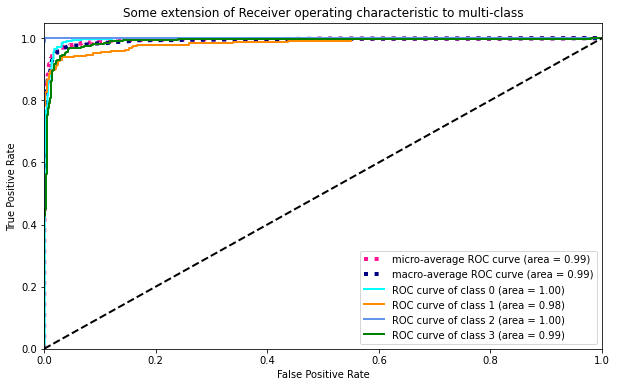

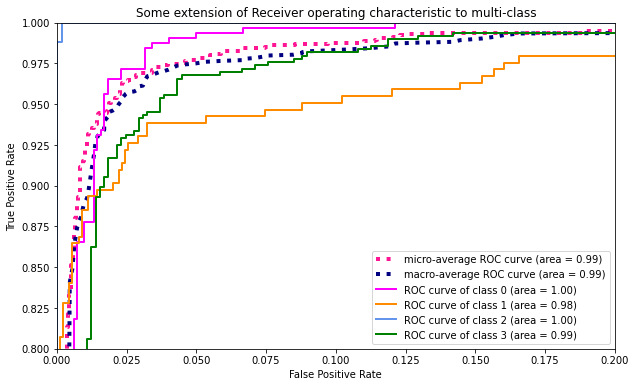

In [ ]:
from sklearn.datasets import make_classification  
from sklearn.preprocessing import label_binarize  
from scipy import interp  
from itertools import cycle

n_classes = 4

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()  
tpr = dict()  
roc_auc = dict() 
for i in range(n_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), preds.ravel())  
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)  
for i in range(n_classes):  
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr  
tpr["macro"] = mean_tpr  
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize= (10,6))  
plt.plot(fpr["micro"], tpr["micro"],  
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],  
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'magenta', 'red','black'])  
for i, color in zip(range(n_classes), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Some extension of Receiver operating characteristic to multi-class')  
plt.legend(loc="lower right")  
plt.savefig("Resultados/ROC_curve.pdf", bbox_inches="tight")
plt.savefig("Resultados/ROC_curve.png", bbox_inches="tight")
plt.show()

# Zoom in view of the upper left corner.
plt.figure(figsize= (10,6))  
plt.xlim(0, 0.2)  
plt.ylim(0.8, 1)  
plt.plot(fpr["micro"], tpr["micro"],  
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],  
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['magenta', 'darkorange', 'cornflowerblue', 'green'])  
for i, color in zip(range(4), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Some extension of Receiver operating characteristic to multi-class')  
plt.legend(loc="lower right")  
plt.savefig("Resultados/ROC_curve_zoom.pdf", bbox_inches="tight")
plt.savefig("Resultados/ROC_curve_zoom.png", bbox_inches="tight")
plt.show()  

In [ ]:
fprsave = {'fpr0': fpr[0],'fpr1': fpr[1],'fpr2': fpr[2],'fpr3': fpr[3],'fprmacro': fpr['macro'],'fprmicro': fpr['micro']}

tprsave = {'tpr0': tpr[0],'tpr1': tpr[1],'tpr2': tpr[2],'tpr3': tpr[3],'tprmacro': tpr['macro'],'tprmicro': tpr['micro']}

rocsave = {'roc0': roc_auc[0],'roc1': roc_auc[1],'roc2': roc_auc[2],'roc3': roc_auc[3],'rocmacro': roc_auc['macro'],'rocmicro': roc_auc['micro']}

In [ ]:
from scipy.io import savemat
import scipy.io as sio

sio.savemat('Resultados/fpr.mat',fprsave)
sio.savemat('Resultados/tpr.mat',tprsave)
sio.savemat('Resultados/roc.mat',rocsave)

In [ ]:
from google.colab import files
!zip -r resultados.zip Resultados
files.download('resultados.zip') 

  adding: Resultados/ (stored 0%)
  adding: Resultados/ROC_curve_zoom.png (deflated 7%)
  adding: Resultados/ROC_curve_zoom.pdf (deflated 27%)
  adding: Resultados/confussion.pdf (deflated 36%)
  adding: Resultados/ROC_curve.png (deflated 9%)
  adding: Resultados/roc.mat (deflated 65%)
  adding: Resultados/fpr.mat (deflated 76%)
  adding: Resultados/loss.png (deflated 4%)
  adding: Resultados/loss.pdf (deflated 34%)
  adding: Resultados/accuracy.png (deflated 4%)
  adding: Resultados/accuracy.pdf (deflated 33%)
  adding: Resultados/confussion.png (deflated 6%)
  adding: Resultados/tpr.mat (deflated 41%)
  adding: Resultados/ROC_curve.pdf (deflated 25%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>